In [1]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer



### Retrieve data from AACT

1. Use this link: [AACT Download](https://aact.ctti-clinicaltrials.org/download).
2. Select pipe-delimited files.
3. Download the latest version of the "Current Month's Daily Static Copies."

- You can find information about each table in the AACT dataset [here](https://aact.ctti-clinicaltrials.org/data_dictionary).



#### conditions.txt
- Name(s) of the disease(s) or condition(s) studied in the clinical study, or the focus of the clinical study. Can include NLM's Medical Subject Heading (MeSH)-controlled vocabulary terms.

In [2]:
# Read conditions file from AACT database
file_path = './AACT_20240125/conditions.txt'

# Select only the nct_id and downcase_name columns
conditions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3])

# Display the DataFrame
conditions.head()

,nct_id,downcase_name
0,NCT05522114,tmd
1,NCT03533179,drug overdose
2,NCT05977569,fasting
3,NCT05976022,mdd
4,NCT04972968,polymyalgia rheumatica


In [3]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
conditions = conditions.groupby('nct_id')['downcase_name'].agg(lambda x: ', '.join(x)).reset_index()
conditions.head()

,nct_id,downcase_name
0,NCT00000102,congenital adrenal hyperplasia
1,NCT00000104,lead poisoning
2,NCT00000105,cancer
3,NCT00000106,rheumatic diseases
4,NCT00000107,"heart defects, congenital"


#### calculated_values.txt

- An AACT-provided table that contains info that's been calculated from the information received from ClinicalTrials.gov. For example, number_of_facilities and actual_duration are provided in this table.

In [4]:
# Read calculated_values file from AACT database
file_path = './AACT_20240125/calculated_values.txt'

# Select only the nct_id and actual_duration columns
calculated_values = pd.read_csv(file_path, header=0, sep="|", usecols=[1,7])

# Display the DataFrame
calculated_values.head()

,nct_id,actual_duration
0,NCT00671619,3.0
1,NCT04838314,26.0
2,NCT05946148,36.0
3,NCT00911664,8.0
4,NCT00867724,46.0


#### studies.txt

- Basic info about study, including study title, date study registered with ClinicalTrials.gov, date results first posted to ClinicalTrials.gov, dates for study start and completion, phase of study, enrollment status, planned or actual enrollment, number of study arms/groups, etc.

In [5]:
# Read facilities file from AACT database
file_path = './AACT_20240125/studies.txt'

# Select only the nct_id, overall_status, phase, and enrollment columns
studies = pd.read_csv(file_path, header=0, sep="|", usecols=[0,35,37,38])

# Filter completed studies 
studies_filtered = studies[studies['overall_status'] == 'Completed']

# Display the DataFrame
studies_filtered.head()

,nct_id,overall_status,phase,enrollment
0,NCT00814619,Completed,Phase 2,68.0
2,NCT01025661,Completed,Not Applicable,14.0
4,NCT00641147,Completed,Phase 2,44.0
5,NCT00460239,Completed,Phase 2,12.0
6,NCT01021605,Completed,Not Applicable,21.0


In [6]:
# Get the position of each column in the studies df
# column_positions = {col: studies.columns.get_loc(col) for col in studies.columns}
# print(column_positions)

#### drop_withdrawals.txt

- Summarized information about how many participants withdrew from the study, when and why. This information explains disposition of participants relative to the numbers starting and completing the study (enumerated in the Milestones table)

In [7]:
# Read drop_withdrawals file from AACT database
file_path = './AACT_20240125/drop_withdrawals.txt'

# Select only the nct_id, reason, and count columns
drop_withdrawals = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,6])

# Display the DataFrame
drop_withdrawals.head()

,nct_id,reason,count
0,NCT01443026,Physician Decision,1.0
1,NCT01443026,Physician Decision,0.0
2,NCT01443026,Death,0.0
3,NCT01443026,Death,1.0
4,NCT01443026,Withdrawal by Subject,0.0


#### milestones.txt

- Information summarizing the progress of participants through each stage of a study, including the number of participants who started and completed the trial. Enumeration of participants not completing the study is included in the Drop_Withdrawals table.

In [8]:
# Read milestones file from AACT database
file_path = './AACT_20240125/milestones.txt'

# Select only the nct_id, title, and count columns
milestones = pd.read_csv(file_path, header=0, sep="|", usecols=[1,4,7])

# Display the DataFrame
milestones.head()

,nct_id,title,count
0,NCT02829723,STARTED,5.0
1,NCT02829723,STARTED,7.0
2,NCT03907579,STARTED,100.0
3,NCT03074500,STARTED,11.0
4,NCT03074500,STARTED,11.0


#### interventions.txt
- The interventions or exposures (including drugs, medical devices, procedures, vaccines, and other products) of interest to the study, or associated with study arms/groups.

In [9]:
# Read interventions file from AACT database
file_path = './AACT_20240125/interventions.txt'

# Select only the nct_id and name columns
interventions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3])

# Display the DataFrame
interventions.head()

,nct_id,name
0,NCT03182764,No intervention
1,NCT05916014,Diagnostic Test: The diagnosis of Artificial I...
2,NCT05916001,Placebo
3,NCT00195676,adalimumab
4,NCT00228332,Administration of zinkgluconaat or placebo


In [10]:
# Make a lowercase copy of the 'name' column
interventions['name'] = interventions['name'].str.lower()

# Drop rows with NaN values in the 'name' column
interventions = interventions.dropna(subset=['name'])

# Filter the rows that contain the word 'vaccine' in the name column
vax_intervention = interventions[interventions['name'].str.contains('vaccine')]
vax_intervention.head()

,nct_id,name
151,NCT00373412,vcl ct02 pdna vaccine
152,NCT00373412,towne cmv vaccine
258,NCT02429440,peptide vaccine
360,NCT00257127,pneumococcal 7-valent conjugate vaccine
372,NCT00257127,pneumococcal polysaccharide vaccine


In [11]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
vax_intervention = vax_intervention.groupby('nct_id')['name'].agg(lambda x: ', '.join(x)).reset_index()
vax_intervention.head()

,nct_id,name
0,NCT00000105,intracel klh vaccine
1,NCT00000583,hepatitis b vaccines
2,NCT00000630,gp160 vaccine (microgenesys)
3,NCT00000631,gp160 vaccine (microgenesys)
4,NCT00000633,"gp160 vaccine (immuno-ag), hepatitis b vaccine..."


#### reported_events.txt
- Summary information about reported adverse events (any untoward or unfavorable medical occurrence to participants, including abnormal physical exams, laboratory findings, symptoms, or diseases), including serious adverse events, other adverse events, and mortality.

In [12]:
# Read reported_events file from AACT database
file_path = './AACT_20240125/reported_events.txt'

# Select only the nct_id, event_type, subjects_affected, subjects_at_risk, event_count, adverse_event_term, and frequency_thresholdt columns
reported_events = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,8,9,11,13,14])

# Display the DataFrame
reported_events.head()

,nct_id,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT02305888,serious,1.0,63,NaN,Inguinal hernia,3.0
1,NCT02305888,serious,0.0,63,NaN,Inguinal hernia,3.0
2,NCT02305888,serious,0.0,62,NaN,Inguinal hernia,3.0
3,NCT02305888,other,28.0,63,NaN,Application site pain,3.0
4,NCT01026402,other,0.0,8,0.0,Hypoalbuminaemia,5.0


#### eligibilities.txt
- Information about the criteria used to select participants; includes inclusion and exclusion criteria.	

In [13]:
# Read eligibilities file from AACT database
file_path = './AACT_20240125/eligibilities.txt'

# select only the nct_id, title, and count columns
eligibilities = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3,4,5])

# Display the DataFrame
eligibilities.head()

,nct_id,gender,minimum_age,maximum_age
0,NCT01165814,Female,NaN,NaN
1,NCT01269086,All,NaN,NaN
2,NCT00367991,All,21 Years,75 Years
3,NCT05766956,All,18 Years,NaN
4,NCT05759572,Female,18 Years,75 Years


In [14]:
# Remove 'Years' from minimum_age and maximum_age columns
eligibilities['minimum_age'] = eligibilities['minimum_age'].str.replace(' Years', '')
eligibilities['maximum_age'] = eligibilities['maximum_age'].str.replace(' Years', '')

# Convert age columns to numeric
eligibilities['minimum_age'] = pd.to_numeric(eligibilities['minimum_age'], errors='coerce')
eligibilities['maximum_age'] = pd.to_numeric(eligibilities['maximum_age'], errors='coerce')

# Replace NaN values in 'maximum_age' with 65 where 'minimum_age' is 18
# Reason: typically, clinical trials include patients aged between 18 and 65 years. 
eligibilities.loc[(eligibilities['minimum_age'] == 18) & (eligibilities['maximum_age'].isna()), 'maximum_age'] = 65

# Calculate mean age
eligibilities['mean_age'] = (eligibilities['minimum_age'] + eligibilities['maximum_age']) / 2

# Display df
eligibilities.head()

,nct_id,gender,minimum_age,maximum_age,mean_age
0,NCT01165814,Female,NaN,NaN,NaN
1,NCT01269086,All,NaN,NaN,NaN
2,NCT00367991,All,21.0,75.0,48.0
3,NCT05766956,All,18.0,65.0,41.5
4,NCT05759572,Female,18.0,75.0,46.5


In [15]:
nan_counts = eligibilities.isna().sum()
nan_counts

nct_id             0
gender           471
minimum_age    47783
maximum_age    77451
mean_age       90893
dtype: int64

#### countries.txt
- Countries in which the study has facilities/sites.

In [16]:
# Read countries file from AACT database
file_path = './AACT_20240125/countries.txt'

# select only the nct_id and name columns
countries = pd.read_csv(file_path, header=0, sep="|", usecols=[1,2])

# Convert 'name' column to string type
countries['name'] = countries['name'].astype(str)

# Convert 'name' column to lowercase
countries['name'] = countries['name'].str.lower()

# Display the DataFrame
countries.head()

,nct_id,name
0,NCT00699179,former serbia and montenegro
1,NCT00699179,serbia
2,NCT00192140,united states
3,NCT04119557,united states
4,NCT04116827,"korea, republic of"


In [17]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
countries = countries.groupby('nct_id')['name'].agg(lambda x: ', '.join(x)).reset_index()
countries.head()

,nct_id,name
0,NCT00000102,united states
1,NCT00000104,united states
2,NCT00000105,united states
3,NCT00000106,united states
4,NCT00000107,united states


In [18]:
# Rename columns for clarity
countries = countries.rename(columns={'name':'country'})
countries.head()

,nct_id,country
0,NCT00000102,united states
1,NCT00000104,united states
2,NCT00000105,united states
3,NCT00000106,united states
4,NCT00000107,united states


#### sponsors.txt
- Name of study sponsors and collaborators. The sponsor is the entity or individual initiating the study. Collaborators are other organizations providing support, including funding, design, implementation, data analysis, and reporting.

In [19]:
# Read sponsors file from AACT database
file_path = './AACT_20240125/sponsors.txt'

# select only the nct_id and agency_class columns
sponsors = pd.read_csv(file_path, header=0, sep="|", usecols=[1,2])

# Remove the duplicates
sponsors = sponsors.drop_duplicates()

# Make a lowercase copy of the 'agency_class' column
sponsors['agency_class'] = sponsors['agency_class'].str.lower()

# Convert 'agency_class' column to string type
sponsors['agency_class'] = sponsors['agency_class'].astype(str)

# Display the DataFrame
sponsors.head()

,nct_id,agency_class
0,NCT00162942,industry
1,NCT02132013,other
3,NCT01559467,other
5,NCT01559480,other
6,NCT01559493,other


In [20]:
# Group rows by the 'nct_id' column and aggregate the 'agency_class' column using a custom lambda function to join strings
sponsors = sponsors.groupby('nct_id')['agency_class'].agg(lambda x: ', '.join(x)).reset_index()
sponsors.head()

,nct_id,agency_class
0,NCT00000102,nih
1,NCT00000104,"nih, fed"
2,NCT00000105,other
3,NCT00000106,nih
4,NCT00000107,nih


In [21]:
# Group rows into 'industry' or 'other' based on the presence of 'industry' in the 'agency_class' column
sponsors['agency_class'] = sponsors['agency_class'].apply(lambda x: 'industry' if 'industry' in x else 'other')
sponsors.head()

,nct_id,agency_class
0,NCT00000102,other
1,NCT00000104,other
2,NCT00000105,other
3,NCT00000106,other
4,NCT00000107,other


#### Preprocess Data for Analysis and Visualization

1. **Data Integration:**
   - Merge multiple datasets using the 'nct_id' to enhance analysis.

2. **Handle Missing Values:**
   - Identify and rectify missing values through techniques such as imputation or removal.

3. **Data Cleaning:**
   - Remove duplicate records where necessary.
   - Rename columns for improved clarity.
   - Eliminate unnecessary columns.
   - Standardize data formats as needed.


##### Create the 'vax_trials' DataFrame

The 'vax_trials' DataFrame should contain fundamental information about completed vaccine clinical trials, including:

- **nct_id:** the unique clinical trial ID.
- **overall_status:** indicates that the clinical trial has been completed
- **phase:** indicates the developmental phase of the vaccine trial.
- **enrollment:** specifies the number of participants enrolled in the clinical trial.
- **vaccine_name:** identifies the specific vaccine under evaluation.
- **condition_name:** describes the medical condition or disease targeted by the vaccine.
- **actual_duration:** represents the duration of the clinical trial from initiation to completion.
- **gender:** represents the gender of the participants, which is described as 'female', 'male', or 'all'.
- **mean_age:** describes the average age of the participants, derived from their minimum and maximum age ranges.
- **country:** name of the country in which the study's facilities/sites are located.
- **agency_class:** describes whether the study's sponsor is from the industry or not.


In [22]:
# Merge 'studies_filtered' and 'vax_intervention' 
vax_trials = pd.merge(studies_filtered, vax_intervention, on='nct_id')

# Remove the duplicates
vax_trials = vax_trials.drop_duplicates()

# Display the df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po..."
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi..."
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth..."
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines


In [23]:
# Merge 'vax_trials' and 'conditions'
vax_trials = pd.merge(vax_trials, conditions, on='nct_id')

# Remove the duplicates
vax_trials = vax_trials.drop_duplicates()

# Display the df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,name,downcase_name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections"
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac..."


In [24]:
# Rename columns for clarity
vax_trials = vax_trials.rename(columns={'name':'vaccine_name', 'downcase_name':'condition_name'})
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections"
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac..."


In [25]:
# Merge 'vax_trials' and 'calculated_values'
vax_trials = pd.merge(vax_trials, calculated_values, on='nct_id')
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",12.0
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,NaN
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac...",8.0


In [26]:
# Fill NaN values with 'Not Applicable' in column 'phase'
vax_trials['phase'] = vax_trials['phase'].fillna('Not Applicable')

In [27]:
# Standardize data formats
unique_names = vax_trials['condition_name'].unique()
unique_names

array(['neisseria meningitidis, meningococcal infections', 'influenza',
       'malaria', ..., 'thalassemia, pneumococcal infection',
       'sexual transmission of infection',
       'recurrent prostate carcinoma, stage i prostate cancer, stage iia prostate cancer, stage iib prostate cancer, stage iii prostate cancer'],
      dtype=object)

In [28]:
# Define the mapping dictionary
mapping = {
    'influenza': 'influenza',
    'flu':'influenza',
    'meningococcal': 'meningococcal',
    'sars-cov-2': 'sars-cov-2',
    'covid': 'sars-cov-2',
    'dengue': 'dengue',
    'hand': 'hand-foot-mouth disease',
    'hpv': 'hpv',
    'papilomavirus': 'hpv ',
    'papillomavirus': 'hpv',
    'hiv': 'hiv',
    'pneumo': 'pneumococcal',
    'streptococcal': 'streptococcal',
    'prostate cancer': 'prostate cancer',
    'inflammatory bowel disease': 'inflammatory bowel disease',
    'breast cancer':'breast cancer',
    'malaria':'malaria',
    'plasmodium falciparum':'malaria',
    'colorectal':'colorectal cancer',   
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials.loc[vax_trials['condition_name'].str.contains(old_value), 'condition_name'] = new_value

In [29]:
# Merge 'vax_trials' and 'eligibilities'
vax_trials = pd.merge(vax_trials, eligibilities, on='nct_id')
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,minimum_age,maximum_age,mean_age
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,16.0,19.0,17.5
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,29.0,60.0,44.5
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,18.0,50.0,34.0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,NaN,NaN
4,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,25.0,53.0,39.0


In [30]:
# Drop columns
columns_to_drop = ['minimum_age', 'maximum_age']
vax_trials = vax_trials.drop(columns=columns_to_drop)
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN
4,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0


In [31]:
# Merge 'vax_trials' and 'countries'
vax_trials = pd.merge(vax_trials, countries, on='nct_id')
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5,japan
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0,united kingdom
3,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0,thailand
4,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany


In [32]:
# Merge 'vax_trials' and 'sponsors'
vax_trials = pd.merge(vax_trials, sponsors, on='nct_id')
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5,japan,industry
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0,united kingdom,other
3,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0,thailand,other
4,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other


In [33]:
# Check if each row contains more than one country
multiple_countries = vax_trials['country'].str.contains(',')

# Replace rows with multiple countries with 'multiple'
vax_trials['country'] = np.where(multiple_countries, 'multiple', vax_trials['country'])

vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5,japan,industry
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0,united kingdom,other
3,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0,thailand,other
4,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other


##### Create the 'vax_trials_with_dropouts' DataFrame

The 'vax_trials_with_dropouts' DataFrame should encompass essential information from both the 'vax_trials' and 'drop_withdrawals' DataFrames, incorporating:

- **reason_dropout:** indicates the reason for dropping out.
- **count_dropout:** denotes the number of participants who dropped out.


In [34]:
# Merge the vaccine clinical trials file with the drop withdrawals file on the NCT Id
vax_trials_with_dropouts = pd.merge(vax_trials, drop_withdrawals, on='nct_id')
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,reason,count
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Lost to Follow-up,1.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Lost to Follow-up,1.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Lost to Follow-up,0.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Withdrawal by Subject,4.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Withdrawal by Subject,5.0


In [35]:
# Rename columns for clarity
vax_trials_with_dropouts = vax_trials_with_dropouts.rename(columns={'reason':'reason_dropout', 'count':'count_dropout'})
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,reason_dropout,count_dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Lost to Follow-up,1.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Lost to Follow-up,1.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Lost to Follow-up,0.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Withdrawal by Subject,4.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,Withdrawal by Subject,5.0


In [36]:
unique_names = vax_trials_with_dropouts['reason_dropout'].unique()
#unique_names

In [37]:
# Standardize Data Formats
# Convert all the strings in the 'reason_dropout' column to lowercase
vax_trials_with_dropouts['reason_dropout'] = vax_trials_with_dropouts['reason_dropout'].str.lower()

In [38]:
# Define a mapping dictionary
mapping = {
    'adverse events': 'adverse event',
    '*clinical ae': 'adverse event',
    'adverse event or death': 'ae or death',
    '*pregnancy':'pregnancy',
    'failure to return':'failed to return'
}

# Apply the mapping to the column
vax_trials_with_dropouts['reason_dropout'] = vax_trials_with_dropouts['reason_dropout'].replace(mapping)

In [39]:
# Define the mapping dictionary
mapping = {
    'move': 'relocate',
    'other': 'others',
    'administrative': 'administrative reason',
    'exclusion': 'met exclusion criteria',
    'non compliance': 'protocol violation/deviation',
    'violation': 'protocol violation/deviation',
    'deviation': 'protocol violation/deviation',
    'physician decision': 'physician decision',
    'adverse event': 'adverse event',
    'withdrawal': 'withdrawal',
    'withdrew': 'withdrawal',
    'died ': 'death'
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_with_dropouts.loc[vax_trials_with_dropouts['reason_dropout'].str.contains(old_value), 'reason_dropout'] = new_value

In [40]:
# Sum of 'count_dropout' grouped by 'nct_id' and 'reason_dropout'
vax_trials_with_dropouts['count_dropout'] = vax_trials_with_dropouts.groupby(['nct_id', 'reason_dropout'])['count_dropout'].transform('sum')

In [41]:
# Remove the duplicates
vax_trials_with_dropouts = vax_trials_with_dropouts.drop_duplicates()
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,reason_dropout,count_dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,lost to follow-up,2.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,withdrawal,12.0
6,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,withdrawal,1.0
8,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,progressive disease,1.0
10,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,NaN,multiple,industry,adverse event,3.0


In [42]:
# List of reasons to keep
reasons_to_keep = ['death', 'withdrawal', 'adverse event', 'lost to follow-up']

# Replace all other reasons with 'other' in a new column
vax_trials_with_dropouts['reason_dropout_filtered'] = np.where(vax_trials_with_dropouts['reason_dropout'].isin(reasons_to_keep), vax_trials_with_dropouts['reason_dropout'], 'other')

# Display df
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,reason_dropout,count_dropout,reason_dropout_filtered
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,lost to follow-up,2.0,lost to follow-up
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,withdrawal,12.0,withdrawal
6,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,withdrawal,1.0,withdrawal
8,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,progressive disease,1.0,other
10,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,NaN,multiple,industry,adverse event,3.0,adverse event


In [43]:
# Calculate the percentage of dropout per reason within each group
vax_trials_with_dropouts_filtered = vax_trials_with_dropouts.groupby(['nct_id', 'reason_dropout_filtered'])['count_dropout'].sum() / vax_trials_with_dropouts['enrollment'].sum() * 100
vax_trials_with_dropouts_filtered

nct_id       reason_dropout_filtered
NCT00003222  other                      0.000019
NCT00005780  other                      0.000019
NCT00006184  death                      0.000019
NCT00030823  withdrawal                 0.000019
NCT00057330  adverse event              0.000394
                                          ...   
NCT05301322  withdrawal                 0.000056
NCT05310084  adverse event              0.000038
             lost to follow-up          0.000038
             other                      0.000188
             withdrawal                 0.000094
Name: count_dropout, Length: 2256, dtype: float64

##### Create the 'vax_trials_with_milestones' DataFrame

The 'vax_trials_with_milestones' DataFrame should encompass essential information from both the 'vax_trials' and 'milestones' DataFrames, incorporating:

- **participant_progress:** indicates whether participants started, completed, or did not complete the trial.
- **participants_number:** refers to the count of participants who started, completed, or did not complete the trial.

In [44]:
# Merge the vaccine clinical trials file with the milestones file on the NCT Id
vax_trials_with_milestones = pd.merge(vax_trials, milestones, on='nct_id')
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,title,count
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,STARTED,145.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,STARTED,142.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,STARTED,163.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,COMPLETED,140.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,COMPLETED,136.0


In [45]:
# Rename columns for clarity
vax_trials_with_milestones = vax_trials_with_milestones.rename(columns={'title':'participant_progress', 'count':'participants_number'})
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,participant_progress,participants_number
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,STARTED,145.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,STARTED,142.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,STARTED,163.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,COMPLETED,140.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,COMPLETED,136.0


In [46]:
# Convert all the strings in the 'participant_progress' column to lowercase
vax_trials_with_milestones['participant_progress'] = vax_trials_with_milestones['participant_progress'].str.lower()

In [47]:
# Sum of 'participants_number' grouped by 'nct_id' and 'participant_progress'
vax_trials_with_milestones['participants_number'] = vax_trials_with_milestones.groupby(['nct_id', 'participant_progress'])['participants_number'].transform('sum')

In [48]:
# Remove the duplicates
vax_trials_with_milestones = vax_trials_with_milestones.drop_duplicates()
vax_trials_with_milestones.head()


,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,participant_progress,participants_number
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,started,450.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,completed,436.0
6,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,not completed,14.0
9,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,started,17.0
11,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,completed,15.0


##### Create the 'vax_trials_with_ae' DataFrame

The 'vax_trials_with_ae' DataFrame should encompass essential information from both the 'vax_trials' and 'reported_events' DataFrames, incorporating:

- **event_type:** indicates whether it was a serious or non-serious adverse event.
- **subjects_affected:** denotes the number of participants affected by an adverse event.	
- **subjects_at_risk:** specifies the number of participants at risk of experiencing an adverse event.
- **adverse_event_term:** refers to the name of the adverse event.

In [49]:
# Merge the vaccine clinical trials file with the reported_events file on the NCT Id
vax_trials_with_ae = pd.merge(vax_trials, reported_events, on='nct_id')
vax_trials_with_ae.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,1.0,144,1.0,Perianal abcess,5.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,0.0,141,0.0,Perianal abcess,5.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,0.0,160,0.0,Perianal abcess,5.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,85.0,142,85.0,Injection site pain,5.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,66.0,138,66.0,Injection site pain,5.0


In [50]:
# Drop columns by labels
columns_to_drop = ['overall_status', 'event_count', 'frequency_threshold']
vax_trials_with_ae = vax_trials_with_ae.drop(columns=columns_to_drop)
vax_trials_with_ae.head()

,nct_id,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,event_type,subjects_affected,subjects_at_risk,adverse_event_term
0,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,1.0,144,Perianal abcess
1,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,0.0,141,Perianal abcess
2,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,0.0,160,Perianal abcess
3,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,85.0,142,Injection site pain
4,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,66.0,138,Injection site pain


In [51]:
# Convert all the strings in the 'adverse_event_term' column to lowercase
vax_trials_with_ae['adverse_event_term'] = vax_trials_with_ae['adverse_event_term'].str.lower()

In [52]:
# Sum of 'subjects_affected' grouped by 'nct_id' and 'adverse_event_term'
vax_trials_with_ae['subjects_affected'] = vax_trials_with_ae.groupby(['nct_id', 'adverse_event_term'])['subjects_affected'].transform('sum')


In [53]:
# Sum of 'subjects_at_risk' grouped by 'nct_id' and 'adverse_event_term'
vax_trials_with_ae['subjects_at_risk'] = vax_trials_with_ae.groupby(['nct_id', 'adverse_event_term'])['subjects_at_risk'].transform('sum')

# Remove the duplicates
vax_trials_with_ae = vax_trials_with_ae.drop_duplicates()

In [54]:
# Display DataFrame
vax_trials_with_ae.head(10)

,nct_id,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,event_type,subjects_affected,subjects_at_risk,adverse_event_term
0,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,serious,1.0,445,perianal abcess
3,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,246.0,438,injection site pain
6,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,115.0,438,injection site erythema
9,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,109.0,438,injection site swelling
12,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,58.0,438,fever
15,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,190.0,438,headache
18,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,177.0,438,malaise
21,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,other,187.0,438,myalgia
24,NCT00623831,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,serious,1.0,17,rapid disease progression
26,NCT00623831,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,serious,2.0,34,increased pleural effusion


In [55]:
# Standardize data formats
unique_names = vax_trials_with_ae['adverse_event_term'].unique()[:50]
unique_names

array(['perianal abcess', 'injection site pain',
       'injection site erythema', 'injection site swelling', 'fever',
       'headache', 'malaise', 'myalgia', 'rapid disease progression',
       'increased pleural effusion', 'pain at injection site',
       'crp elevation', 'edema', 'weakness', 'chills', 'hypertension',
       'hypotension', 'nausea', 'tachycardia', 'anemia', 'cough',
       'fatigue', 'flu-like feeling', 'increased dyspnea', 'vertigo',
       'abrasion head', 'angina tonsillaris', 'arthralgia',
       'bladder pressure', 'bone pain', 'bradycardia',
       'candida infection urine', 'co-reaction of prior injection sites',
       'common cold', 'constipation', 'decubitus', 'diarrhea',
       'epistaxis', 'expectoration', 'feeling of pressure in head',
       'heartburn', 'hematoma due to fall (by accident)',
       'herpes labialis', 'hypokalemia', 'inappetence', 'increased pain',
       'increased swollen tongue', 'increased visual disturbance',
       'infection', 'i

In [56]:
# Define the mapping dictionary
mapping = {
    'injection':'injection site reactions',
    'fever':'pyrexia'
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_with_ae.loc[vax_trials_with_ae['adverse_event_term'].str.contains(old_value), 'adverse_event_term'] = new_value

In [57]:
# Drop columns
pivot_ae = vax_trials_with_ae.drop(columns=['event_type', 'subjects_at_risk'])

# Pivot the DataFrame to have one row per unique clinical trial ID (NCTId)
pivot_ae = vax_trials_with_ae.pivot_table(index=['nct_id'],
                          columns='adverse_event_term',
                          values='subjects_affected',
                          aggfunc='sum',
                          fill_value=0).reset_index()

# Reset the index to make NCTId a column
pivot_ae.reset_index(drop=True, inplace=True)

In [58]:
# Display DataFrame
pivot_ae.head()

adverse_event_term,nct_id,1-minute apgar score of 7 or less,2009 h1n1 pneumonia/lrti,21-hydroxylase deficiency,aat increase,abasia,abbdominal pain,abcess,abdomen nos,abdomen pain,...,wound necrosis,wound secretion,wound sepsis,wrist fracture,xanthoma,xeroderma,xerosis,xerostomia,xyy syndrome,zika virus infection
0,NCT00003222,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NCT00005780,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NCT00006184,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NCT00030823,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NCT00053482,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Select top 5 AE events
pivot_top5_AE = pivot_ae[['nct_id', 'injection site reactions', 'pyrexia', 'headache', 'irritability', 'pain']]
pivot_top5_AE.head()

adverse_event_term,nct_id,injection site reactions,pyrexia,headache,irritability,pain
0,NCT00003222,30,44,21,0,0
1,NCT00005780,0,5,10,0,0
2,NCT00006184,20,10,4,0,0
3,NCT00030823,13,1,1,0,0
4,NCT00053482,549,0,0,0,0


#### Data Analysis and Visualization


In [60]:
# define function to calculate the total count for each condition

def total_count(dataframe, column_id, condition):
    new_df = dataframe[[column_id, condition]] 
    new_df = new_df.drop_duplicates()
    # Calculate the total count for each condition
    total_counts = new_df[condition].value_counts().reset_index()
    # Rename the columns for clarity
    total_counts.columns = [condition, 'TotalCount']
    return total_counts


# define function to sum the values in the 'count' column

def sum_count(dataframe, column_1, count):
    new_df = dataframe[[column_1, count]]  
    # Sum the values in the 'count' column
    grouped_df = new_df.groupby(column_1)[count].sum().reset_index()  
    # Rename the columns for clarity
    grouped_df.columns = [column_1, 'TotalSum']  
    return grouped_df  


In [61]:
# define function to plot top 10

def plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Select the top 10 rows
    top_10 = dataframe.head(10)[::-1]
    
    # Create a bar chart for the top 10, sorted in descending order
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()
    
    
def plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Sort the dataframe by y_column in descending order
    sorted_df = dataframe.sort_values(by=y_column, ascending=False)
    
    # Select the top 10 rows
    top_10 = sorted_df.head(10)[::-1]
    
    # Create a bar chart for the top 10
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()


##### Visualize the distribution of clinical trials by phase


In [62]:
# Get value counts for the Phase column
phase_counts = vax_trials['phase'].value_counts()
phase_counts

Phase 3            718
Phase 2            683
Phase 1            670
Phase 4            375
Not Applicable     322
Phase 1/Phase 2    182
Phase 2/Phase 3     44
Early Phase 1       26
Name: phase, dtype: int64

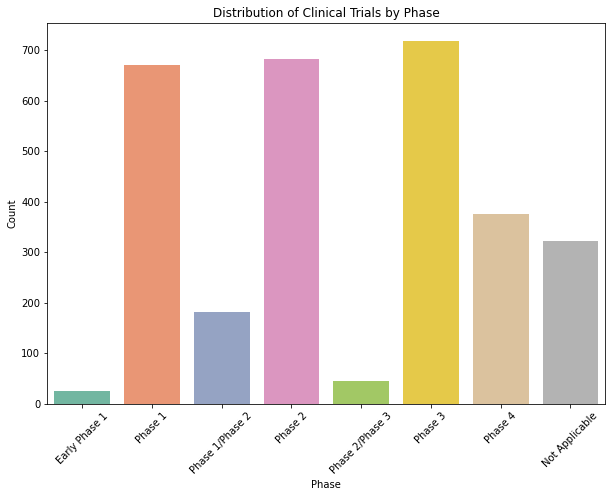

In [63]:
# Plot the distribution of clinical trials by phase

# Select only 'nct_id' and 'phase' columns
phase_df = vax_trials[['nct_id', 'phase']]
phase_df = phase_df.drop_duplicates()


# Define the order for phases
phase_order = ['Early Phase 1', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 'Phase 3', 'Phase 4', 'Not Applicable']


# Set the figure size
plt.figure(figsize=(10, 7))

# Plot a countplot
sns.countplot(x='phase', data=phase_df, palette='Set2', order=phase_order)
plt.title('Distribution of Clinical Trials by Phase')
plt.xlabel('Phase')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

##### Identify the most frequently reported reasons for patients discontinuing their participation in clinical trials related to vaccine interventions.

In [64]:
# Utilize the 'sum_count' function to extract the 'reason_dropout' and 'count_dropout' columns from the dataframe
# and sum the values in the 'count_dropout' column

reason_sum = sum_count(vax_trials_with_dropouts, 'reason_dropout', 'count_dropout')
reason_sum.head()

,reason_dropout,TotalSum
0,6-month contact; withdraw before vax 2,123.0
1,administrative reason,698.0
2,adverse event,6397.0
3,ae or death,56.0
4,alternative therapy,3.0


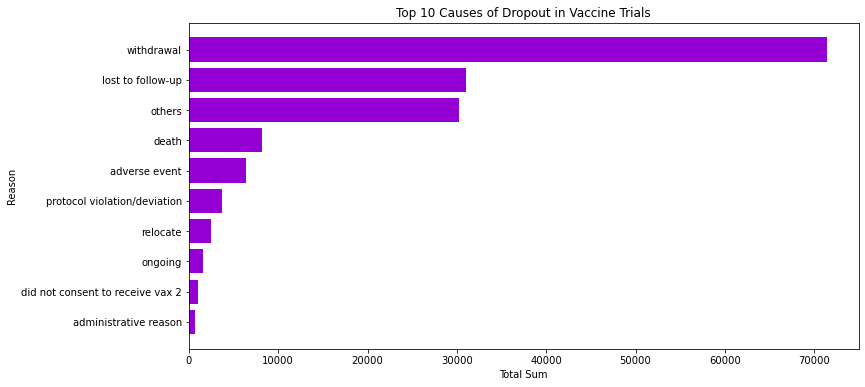

In [65]:
# Plot
dataframe = reason_sum
x_column = 'reason_dropout'
y_column = 'TotalSum'
title = 'Top 10 Causes of Dropout in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Reason'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)


##### Determine the most prevalent conditions in vaccine clinical trials

In [66]:
# Utilize the 'total_count' function to extract the 'nct_id' and 'condition_name' columns from the dataframe
# and compute the total count of unique conditions present in the 'condition_name' column.


condition_counts = total_count(vax_trials, 'nct_id', 'condition_name')
condition_counts.head()

,condition_name,TotalCount
0,influenza,756
1,meningococcal,159
2,sars-cov-2,153
3,hiv,144
4,pneumococcal,109


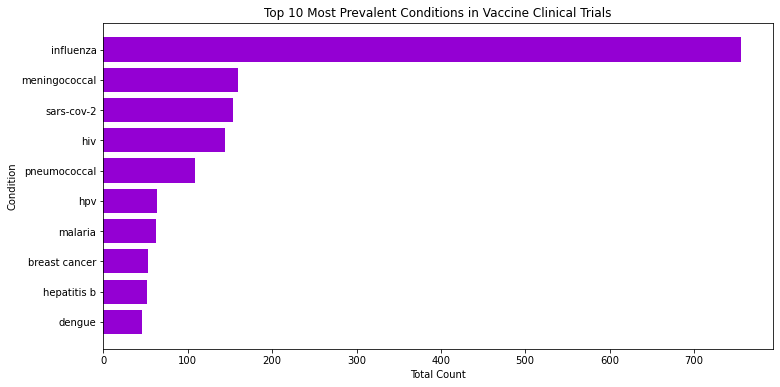

In [67]:
# Plot

dataframe = condition_counts
x_column = 'condition_name'
y_column = 'TotalCount'
title = 'Top 10 Most Prevalent Conditions in Vaccine Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Condition'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

##### Determine the prevalence of vaccines utilized as interventions in clinical trials 

In [68]:
# Utilize the 'total_count' function to extract the 'nct_id' and 'vaccine_name' columns from the dataframe
# and compute the total count of unique vaccines present in the 'vaccine_name' column.

interventions_count = total_count(vax_trials, 'nct_id', 'vaccine_name')
interventions_count.head()

,vaccine_name,TotalCount
0,influenza vaccine,35
1,rabies vaccine,18
2,pfspz vaccine,17
3,hepatitis b vaccine,17
4,bcg vaccine,13


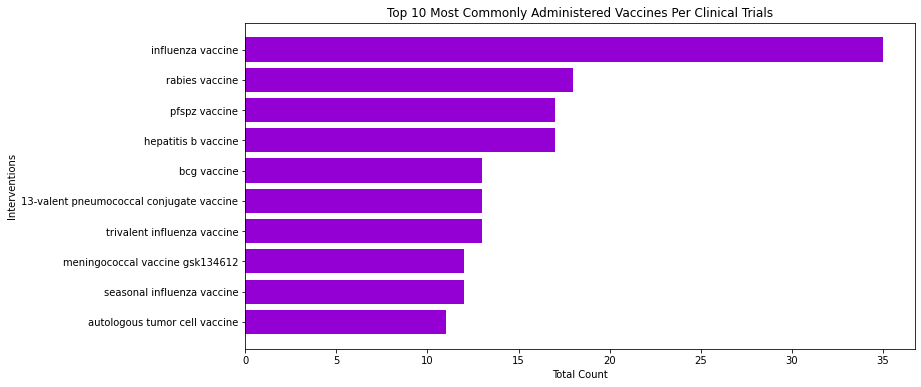

In [69]:
# Plot
dataframe = interventions_count
x_column = 'vaccine_name'
y_column = 'TotalCount'
title = 'Top 10 Most Commonly Administered Vaccines Per Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Interventions'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

##### Summary of participants' progress in the study, including the count of those who started and completed the trial.

In [70]:
# use the 'sum_count' function to select the 'Status' and 'Count' columns and sum the values in the 'Count' column

progress_sum = sum_count(vax_trials_with_milestones, 'participant_progress', 'participants_number')
progress_sum.head()

,participant_progress,TotalSum
0,1 year visit,254.0
1,1- month post-op,13.0
2,15-day follow-up,146.0
3,3 month follow-up,143.0
4,3-6 months post-op,12.0


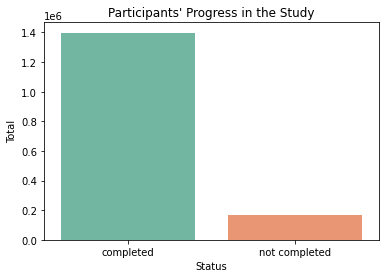

In [71]:
# Filter rows where the 'Title' column is either 'completed' or 'not completed'
progress_filtered = progress_sum[progress_sum['participant_progress'].isin(['completed', 'not completed'])]

# Plot a barplot
sns.barplot(x='participant_progress', y='TotalSum', data=progress_filtered, palette='Set2')
plt.title('Participants\' Progress in the Study')
plt.xlabel('Status')
plt.ylabel('Total')
plt.show()


##### Identify the most prevalent adverse events in vaccine clinical trials

In [72]:
ae_sum = sum_count(vax_trials_with_ae, 'adverse_event_term', 'subjects_affected')
ae_sum = ae_sum.sort_values(by='TotalSum', ascending=False)
ae_sum.head()

,adverse_event_term,TotalSum
3650,injection site reactions,388438.0
6018,pyrexia,163756.0
5182,pain,123820.0
3767,irritability,123514.0
3031,headache,121009.0


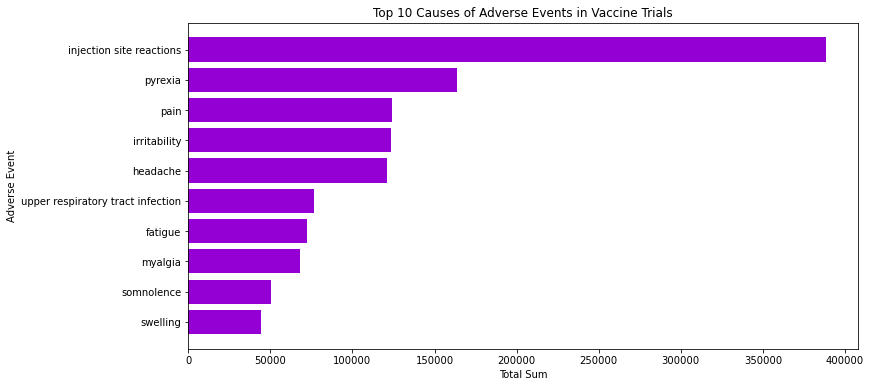

In [73]:
# Plot
dataframe = ae_sum
x_column = 'adverse_event_term'
y_column = 'TotalSum'
title = 'Top 10 Causes of Adverse Events in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Adverse Event'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)

##### Summary of participants' types of adverse events, whether serious or not.

In [74]:
event_sum = sum_count(vax_trials_with_ae, 'event_type', 'subjects_affected')
event_sum = event_sum.sort_values(by='TotalSum', ascending=False)
event_sum.head()

,event_type,TotalSum
0,other,1969805.0
1,serious,386980.0


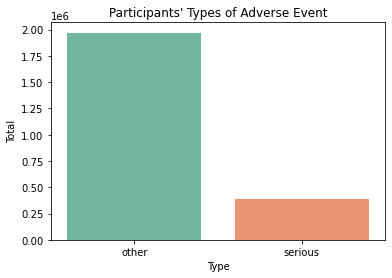

In [75]:
# Plot a barplot
sns.barplot(x='event_type', y='TotalSum', data=event_sum, palette='Set2')
plt.title('Participants\' Types of Adverse Event')
plt.xlabel('Type')
plt.ylabel('Total')
plt.show()

#### Preprocessing the Data for Machine Learning Models

1. **Data Integration:**
   - Merge multiple datasets using the 'nct_id' to enhance analysis.

2. **Handle Missing Values:**
   - Identify and rectify missing values through techniques such as imputation or removal.

3. **Data Cleaning:**
   - Remove duplicate records where necessary.
   - Rename columns for improved clarity.
   - Eliminate unnecessary columns.
   - Standardize data formats as needed.


- Data aggregation: dropout

In [76]:
# Filter out 'started' status
vax_trials_with_milestones = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] != 'started']

# Aggregate p'articipant_progress' counts at the clinical trial level
completed_counts = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] == 'completed'].groupby('nct_id')['participants_number'].sum()
not_completed_counts = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] == 'not completed'].groupby('nct_id')['participants_number'].sum()

# Merge aggregated counts
aggregated_milestones = pd.merge(completed_counts, not_completed_counts, on='nct_id', how='outer', suffixes=('_completed', '_not_completed'))

In [77]:
# Create binary target column indicating whether there are any dropouts for each clinical trial
# 0: no dropouts, 1: at least one dropout
aggregated_milestones['dropout'] = (aggregated_milestones['participants_number_not_completed'] > 0).astype(int)
aggregated_milestones.reset_index(inplace=True)
aggregated_milestones.head()

,nct_id,participants_number_completed,participants_number_not_completed,dropout
0,NCT00003222,40.0,1.0,1
1,NCT00005780,49.0,1.0,1
2,NCT00006184,19.0,1.0,1
3,NCT00030823,13.0,1.0,1
4,NCT00053482,357.0,0.0,0


In [78]:
# Count the occurrences of 0s and 1s in the 'dropout' column
dropout_counts = aggregated_milestones['dropout'].value_counts()

# Display the counts
print(dropout_counts)


1    905
0    163
Name: dropout, dtype: int64


- Data aggregation: adverse events

In [79]:
# Aggregate status counts at the clinical trial level
serious_counts = vax_trials_with_ae[vax_trials_with_ae['event_type'] == 'serious'].groupby('nct_id')['subjects_affected'].sum()
other_counts = vax_trials_with_ae[vax_trials_with_ae['event_type'] == 'other'].groupby('nct_id')['subjects_affected'].sum()

# Merge aggregated counts
aggregated_event_type = pd.merge(serious_counts, other_counts, on='nct_id', how='outer', suffixes=('_serious', '_other'))

# Reset index
aggregated_event_type.reset_index(inplace=True)

# Display df
aggregated_event_type.head()

,nct_id,subjects_affected_serious,subjects_affected_other
0,NCT00003222,60.0,396.0
1,NCT00005780,57.0,597.0
2,NCT00006184,138.0,436.0
3,NCT00030823,2.0,33.0
4,NCT00053482,2.0,1412.0


In [80]:
# Rename columns
aggregated_event_type = aggregated_event_type.rename(columns={'subjects_affected_serious':'AE_total_serious', 'subjects_affected_other':'AE_total_other'})
aggregated_event_type.head()

,nct_id,AE_total_serious,AE_total_other
0,NCT00003222,60.0,396.0
1,NCT00005780,57.0,597.0
2,NCT00006184,138.0,436.0
3,NCT00030823,2.0,33.0
4,NCT00053482,2.0,1412.0


Data integration

- merge 'vax_trials' with 'aggregated_milestones'

In [81]:
df_ml = pd.merge(vax_trials, aggregated_milestones, on='nct_id')
df_ml.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,country,agency_class,participants_number_completed,participants_number_not_completed,dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,saudi arabia,industry,436.0,14.0,1
1,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,41.5,germany,other,15.0,2.0,1
2,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,NaN,multiple,industry,2697.0,13.0,1
3,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal,13.0,All,6.0,multiple,industry,2802.0,105.0,1
4,NCT05293392,Completed,Not Applicable,5792.0,culturally-tailored covid-19 vaccine uptake in...,sars-cov-2,3.0,All,NaN,united states,other,5750.0,0.0,0


In [82]:
# Calculate dropout rates as a percentage
df_ml['dropout_rate'] = (df_ml['participants_number_not_completed'] / df_ml['enrollment']) * 100

In [83]:
# Count the number of missing values in each column
na_counts = df_ml.isna().sum()
print(na_counts)

nct_id                                 0
overall_status                         0
phase                                  0
enrollment                             0
vaccine_name                           0
condition_name                         0
actual_duration                        1
gender                                 0
mean_age                             437
country                                0
agency_class                           0
participants_number_completed          0
participants_number_not_completed      0
dropout                                0
dropout_rate                           0
dtype: int64


Imputation: mean age

In [84]:
# Column name you want to impute
column_name_to_impute = 'mean_age_imp'

# Extract the column you want to impute as a DataFrame with a single column
column_to_impute = df_ml[['mean_age']]  

# Create SimpleImputer instance
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit and transform the imputer on the selected column
column_to_impute = pd.DataFrame(imp.fit_transform(column_to_impute), columns=[column_name_to_impute])

# Replace the imputed column in the original DataFrame
df_ml[column_name_to_impute] = column_to_impute[column_name_to_impute]
df_ml.drop(columns=['mean_age'], inplace=True)

In [85]:
df_ml.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,country,agency_class,participants_number_completed,participants_number_not_completed,dropout,dropout_rate,mean_age_imp
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,saudi arabia,industry,436.0,14.0,1,3.111111,17.500000
1,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,germany,other,15.0,2.0,1,11.764706,41.500000
2,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,multiple,industry,2697.0,13.0,1,1.818182,33.899366
3,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal,13.0,All,multiple,industry,2802.0,105.0,1,3.611971,6.000000
4,NCT05293392,Completed,Not Applicable,5792.0,culturally-tailored covid-19 vaccine uptake in...,sars-cov-2,3.0,All,united states,other,5750.0,0.0,0,0.000000,33.899366


In [86]:
# Drop NA
df_ml = df_ml.dropna()

Data integration

- merge 'df_ml' with 'aggregated_event_types'

In [87]:
df_ml = pd.merge(df_ml, aggregated_event_type, on='nct_id')
df_ml.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,country,agency_class,participants_number_completed,participants_number_not_completed,dropout,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,saudi arabia,industry,436.0,14.0,1,3.111111,17.500000,1.0,1082.0
1,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,germany,other,15.0,2.0,1,11.764706,41.500000,3.0,100.0
2,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,multiple,industry,2697.0,13.0,1,1.818182,33.899366,349.0,1716.0
3,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal,13.0,All,multiple,industry,2802.0,105.0,1,3.611971,6.000000,119.0,4625.0
4,NCT04515147,Completed,Phase 2,668.0,"hepatitis a vaccine, pneumococcal vaccine",sars-cov-2,17.0,All,multiple,industry,611.0,57.0,1,8.532934,41.500000,140.0,3398.0


In [88]:
# Count the number of missing values in each column
na_counts = df_ml.isna().sum()
print(na_counts)

nct_id                                 0
overall_status                         0
phase                                  0
enrollment                             0
vaccine_name                           0
condition_name                         0
actual_duration                        0
gender                                 0
country                                0
agency_class                           0
participants_number_completed          0
participants_number_not_completed      0
dropout                                0
dropout_rate                           0
mean_age_imp                           0
AE_total_serious                     201
AE_total_other                        34
dtype: int64


In [89]:
# Fill NaN values with 0
df_ml = df_ml.fillna(0)

In [90]:
# Check for duplicates
duplicates = df_ml.duplicated()
print(duplicates.value_counts())

False    1006
dtype: int64


In [91]:
# Drop columns
df_ml = df_ml.drop(columns=['overall_status', 'vaccine_name', 'participants_number_completed', 'participants_number_not_completed', 'dropout'])
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other
0,NCT00444951,Phase 3,450.0,meningococcal,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0
1,NCT00623831,Phase 1,17.0,prostate cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0
2,NCT00434577,Phase 2,715.0,herpes zoster,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0
3,NCT00616421,Phase 3,2907.0,meningococcal,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0
4,NCT04515147,Phase 2,668.0,sars-cov-2,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0


- Groupping 'condition_name'

    - infectious diseases;
    - cancer;
    - inflammatory diseases;
    - autoimmune diseases;
    - congenital disorders;
    - allergy;
    - chronic diseases;
    - transplant;
    - respiratory disorders;
    - heart diseases.


In [92]:
# Define the mapping dictionary
mapping = {
    'influenza':'infectious diseases',
    'sars-cov-2':'infectious diseases',
    'dengue':'infectious diseases',
    'hand':'infectious diseases',
    'hpv':'infectious diseases',
    'hiv':'infectious diseases',
    'meningococcal':'infectious diseases',
    'pneumococcal':'infectious diseases',
    'streptococcal':'infectious diseases',
    'inflammatory bowel disease':'inflammatory diseases',
    'cancer':'cancer',
    'malaria':'infectious diseases',
    'herpes zoster':'infectious diseases',
    'virus':'infectious diseases',
    'bacteria':'infectious diseases',
    'carcinomatosis':'cancer',
    'carcinoma':'cancer',
    'smallpox':'infectious diseases',
    'sarcoma':'cancer',
    'leukemia':'cancer',
    'neoplasm':'cancer',
    'hepatitis b':'infectious diseases',
    'poliomyelitis':'infectious diseases',
    'hepatitis':'infectious diseases',
    'tuberculosis':'infectious diseases',
    'rabies':'infectious diseases',
    'melanoma':'cancer',
    'yeast infections':'infectious diseases',
    'tumors':'cancer',
    'candidiasis':'infectious diseases',
    'streptococcus':'infectious diseases',
    'congenital':'congenital disorders',
    'chikungunya':'infectious diseases',
    'rubella':'infectious diseases',
    'varicella':'infectious diseases',
    'mumps':'infectious diseases',
    'measles':'infectious diseases',
    'herpes':'infectious diseases',
    'meningitidis':'infectious diseases',
    'cholera':'infectious diseases',
    'pertussis':'infectious diseases',
    'infectious diseases':'infectious diseases',
    'lymphoma':'cancer',
    'glioma':'cancer',
    'aids':'infectious diseases',
    'yellow fever':'infectious diseases',
    'bacillary':'infectious diseases',
    'mers':'infectious diseases',
    'viral':'infectious diseases',
    'polio':'infectious diseases',
    'infections':'infectious diseases',
    'clostridium':'infectious diseases',
    'ebola':'infectious diseases',
    'healthy':'healthy',
    'allergy':'allergy',
    'meningitis':'infectious diseases',
    'pregnancy':'pregnancy',
    'gastroenteritis':'infectious diseases',
    'bronchiolitis':'infectious diseases',
    'squamous intraepithelial lesion':'cancer',
    'dermatitis':'inflammatory diseases',
    'multiple sclerosis':'autoimmune diseases',
    'typhoid':'infectious diseases',
    'japanese encephalitis':'infectious diseases',
    'encephalitis':'infectious diseases',
    'shigella':'infectious diseases',
    'glioblastoma':'cancer',
    'myeloma':'cancer',
    'rheumatoid arthritis':'autoimmune diseases',
    'arthritis, rheumatoid':'autoimmune diseases',
    'chronic':'chronic diseases',
    'shigellosis':'infectious diseases',
    'diphtheria':'infectious diseases', 
    'tetanus':'infectious diseases',
    'infection':'infectious diseases', 
    'asthma':'chronic diseases',
    'transplant':'transplant',
    'condylomata acuminata':'infectious diseases',
    'neoplasia':'cancer',
    'allergic':'allergy',
    'west nile fever':'infectious diseases',
    'tularemia':'infectious diseases',
    'q fever':'infectious diseases',
    'efficacy of the new cprv':'infectious diseases',
    'toxic shock syndrome':'infectious diseases',
    'heart':'heart diseases',
    'shingles':'infectious diseases',
    'end stage renal disease':'chronic diseases',
    'sepsis':'infectious diseases',
    'hemorrhagic fever with renal syndrome':'infectious diseases',
    'rift valley fever':'infectious diseases',  
    
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    df_ml.loc[df_ml['condition_name'].str.contains(old_value), 'condition_name'] = new_value

In [93]:
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0


In [94]:
values_to_drop = [
    'vaccine response impaired',
    'vomiting, diarrhea, fever',
    'prospective, single-blind, clinical, trial, intervention',
    'innate immune response',
    'diarrhea',
    'safety, adverse event following immunisation, birth outcomes',
    'vaccine',
    'nicotine dependence',
    'non-target heterologous effects of vaccines, vaccine interactions',
    'dose schedule study',
    'short bowel syndrome'
]

# Drop rows containing the specified values in the column
df_ml = df_ml[~df_ml['condition_name'].isin(values_to_drop)]

# Print the filtered DataFrame
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,country,agency_class,dropout_rate,mean_age_imp,AE_total_serious,AE_total_other
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,saudi arabia,industry,3.111111,17.500000,1.0,1082.0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,germany,other,11.764706,41.500000,3.0,100.0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,multiple,industry,1.818182,33.899366,349.0,1716.0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,multiple,industry,3.611971,6.000000,119.0,4625.0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,multiple,industry,8.532934,41.500000,140.0,3398.0


In [95]:
# Print the unique disease names
unique_diseases = df_ml['condition_name'].unique()
print(unique_diseases)

['infectious diseases' 'cancer' 'inflammatory diseases' 'healthy'
 'autoimmune diseases' 'congenital disorders' 'allergy' 'chronic diseases'
 'transplant' 'respiratory disorders' 'pregnancy' 'heart diseases']


In [96]:
# # Merge 'df_ml' and 'pivot_top5_AE' 
# df_ml = pd.merge(df_ml, pivot_top5_AE, on='nct_id')

# # Remove the duplicates
# df_ml = df_ml.drop_duplicates()

# # Display the df
# df_ml.head()

In [97]:
# Save the DataFrame to a CSV file
df_ml.to_csv('./data/vax_trials_ml_df.csv', index=False)